In [1]:
from dataset import dataset, Encoder, Collate
from model import CRNNModel
import transform

import torch
from torch.utils.data import DataLoader
import albumentations as A
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
_, _, testset = dataset('IAM', '/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed',
                                    csv_file_path='IAM_df.csv', default_partition=False, partition=(0.7, 0.1, 0.2), shuffle=False, seed=42)

In [5]:
print(len(testset))
testset.data.head()

2670


,Image,Segmentation,Transcription,Threshold
0,l07-135-08,err,the river and in and out of the other boats.,175
1,l07-138-00,ok,"It was a warm, still evening; the plop of",181
2,l07-138-01,ok,fish and the gentle putter of the engine,185
3,l07-138-02,ok,"were infinitely soothing after city noises,",183
4,l07-138-03,ok,and I began to look forward to my life,185


In [6]:
encoder = Encoder(testset.charset)
collater = Collate(encoder)

test_loader = DataLoader(testset,
    batch_size=16,
    shuffle=True, 
    collate_fn=collater,
    num_workers=0
)

test_batch = next(iter(test_loader))
images, targets, target_lengths, ground_truth = test_batch

In [7]:
model = CRNNModel(vocab_size=79, time_steps=100)

device = torch.device('cpu')
checkpoint = torch.load(
    'checkpoints/training_state.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [6]:
dev = 'cpu'

with torch.no_grad():

    model.to(dev)
    images = images.to(dev)
    targets = targets.to(dev)
    target_lengths = target_lengths.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

In [7]:
ground_truth

('He looked at Price the Provisions, who was nursing',
 'dance," Doc\'s cheery voice came as a',
 'between what a senior and a junior',
 'of lovely-ugly to be coldly elegant in. All this',
 'both at midnight." They might have been',
 'tigerfly is not a tigerfly until it changes. So humans',
 'But privately he turned out to be as friendly as',
 'again, no doubt, and then you will have.',
 '"Yeah," said Dowd dubiously. "2Mebbe we\'d',
 "That's how he got the votes, that's how",
 'Negresco, and went to the beach to',
 "Seaweed's memory was prodigious; her manner",
 'same empty streets as he had the night before,',
 'Junior Medical Officer. "You won\'t be free about nine, I',
 'Where indeed? Megan Thomas spoke sharply',
 "island I needn't tell you that Sir John")

In [8]:
preds_decoded

['He looed at Pnice the Provisions, who was nmurning',
 'daneey" Dos cheery vorice came as a',
 'selocen cobet esearis ened e pcese-',
 'of lovely-ugly to be calaly ellegaut Mn.Al kmis',
 'bortke at midughet." Rey anger have bec',
 'rigerfly is not a tigefly until it changes. So hurmans',
 'bert prrivmartely be tunad or to be as tveinadly as',
 'agan no deulst, and then yer will have',
 '"Yean," sand Dowd duirbiounsf. "TNeade we\'d',
 "That's how he got the votes, that's hon",
 'Negrer-o, and ment to the becaoh to',
 'Seanreed is smsmosy 2as poroadiguious; her smasoner',
 'ravene ceupt otseets ar hie had the egighl fefose,',
 'Aumise muntne orrceR. Nn hewir t rest Asour ihr, ',
 'Where inded? Megas Thomas spoke shasply',
 'island ineditf koo poce bet r fohe']

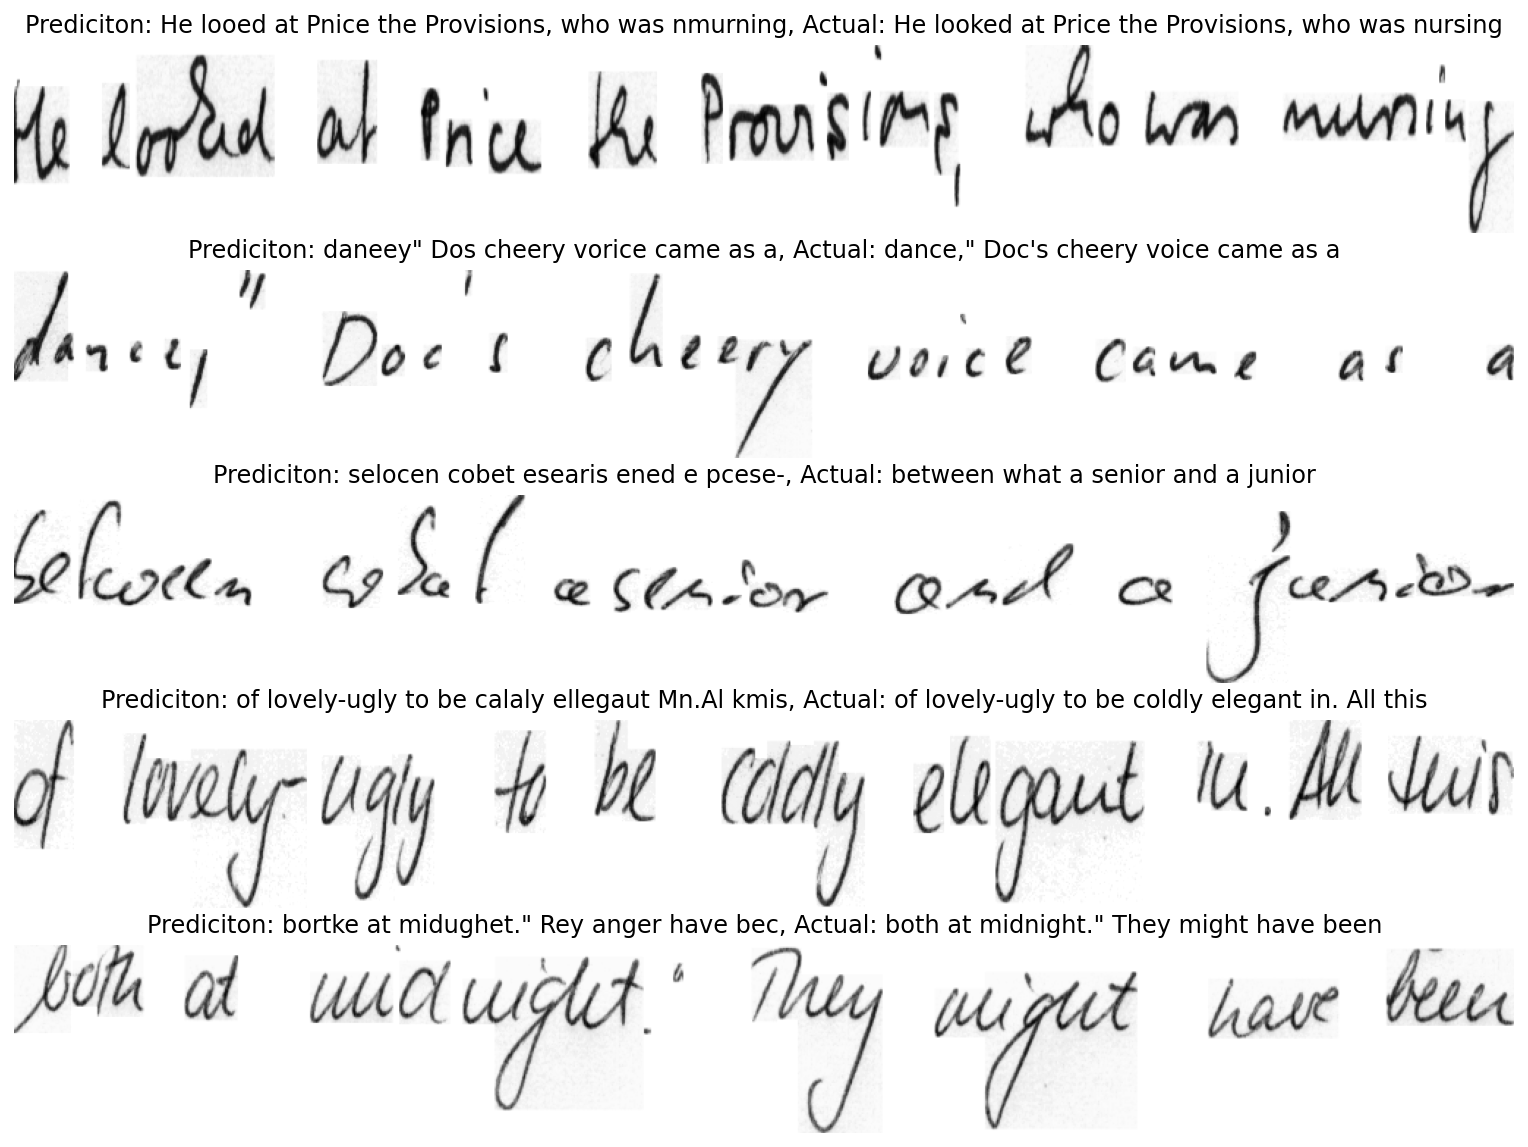

In [9]:
f, axes = plt.subplots(nrows=len(images[:5]), ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:5]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Prediciton: {preds_decoded[i]}, Actual: {ground_truth[i]}")

## Actual images

In [3]:
real_image01 = cv2.imread('images/college.jpg', cv2.IMREAD_GRAYSCALE)
real_image02 = cv2.imread('images/projectname-001.jpg', cv2.IMREAD_GRAYSCALE)
real_image03 = cv2.imread('images/projectname-002.jpg', cv2.IMREAD_GRAYSCALE)
real_image04 = cv2.imread('images/projectname-003.jpg', cv2.IMREAD_GRAYSCALE)

real_images = [real_image01, real_image02, real_image03, real_image04]

In [11]:
transforms = A.Compose([
                A.augmentations.geometric.Resize(
                    height=128, width=1024, p=1.0, always_apply=True),
                transform.Rotate(always_apply=True, p=1.0),
                transform.ToTensor(always_apply=True, p=1.0)
            ])
resized_real_images = []
for image in real_images:
    resized_real_image = transforms(image=image)['image']
    resized_real_images.append(resized_real_image)

In [12]:
dev = 'cpu'

with torch.no_grad():

    model.to(dev)
    images = torch.stack(resized_real_images, dim=0)
    images = images.to(dev)

    preds = model(images)
    preds_decoded = encoder.best_path_decode(
        preds, return_text=True)

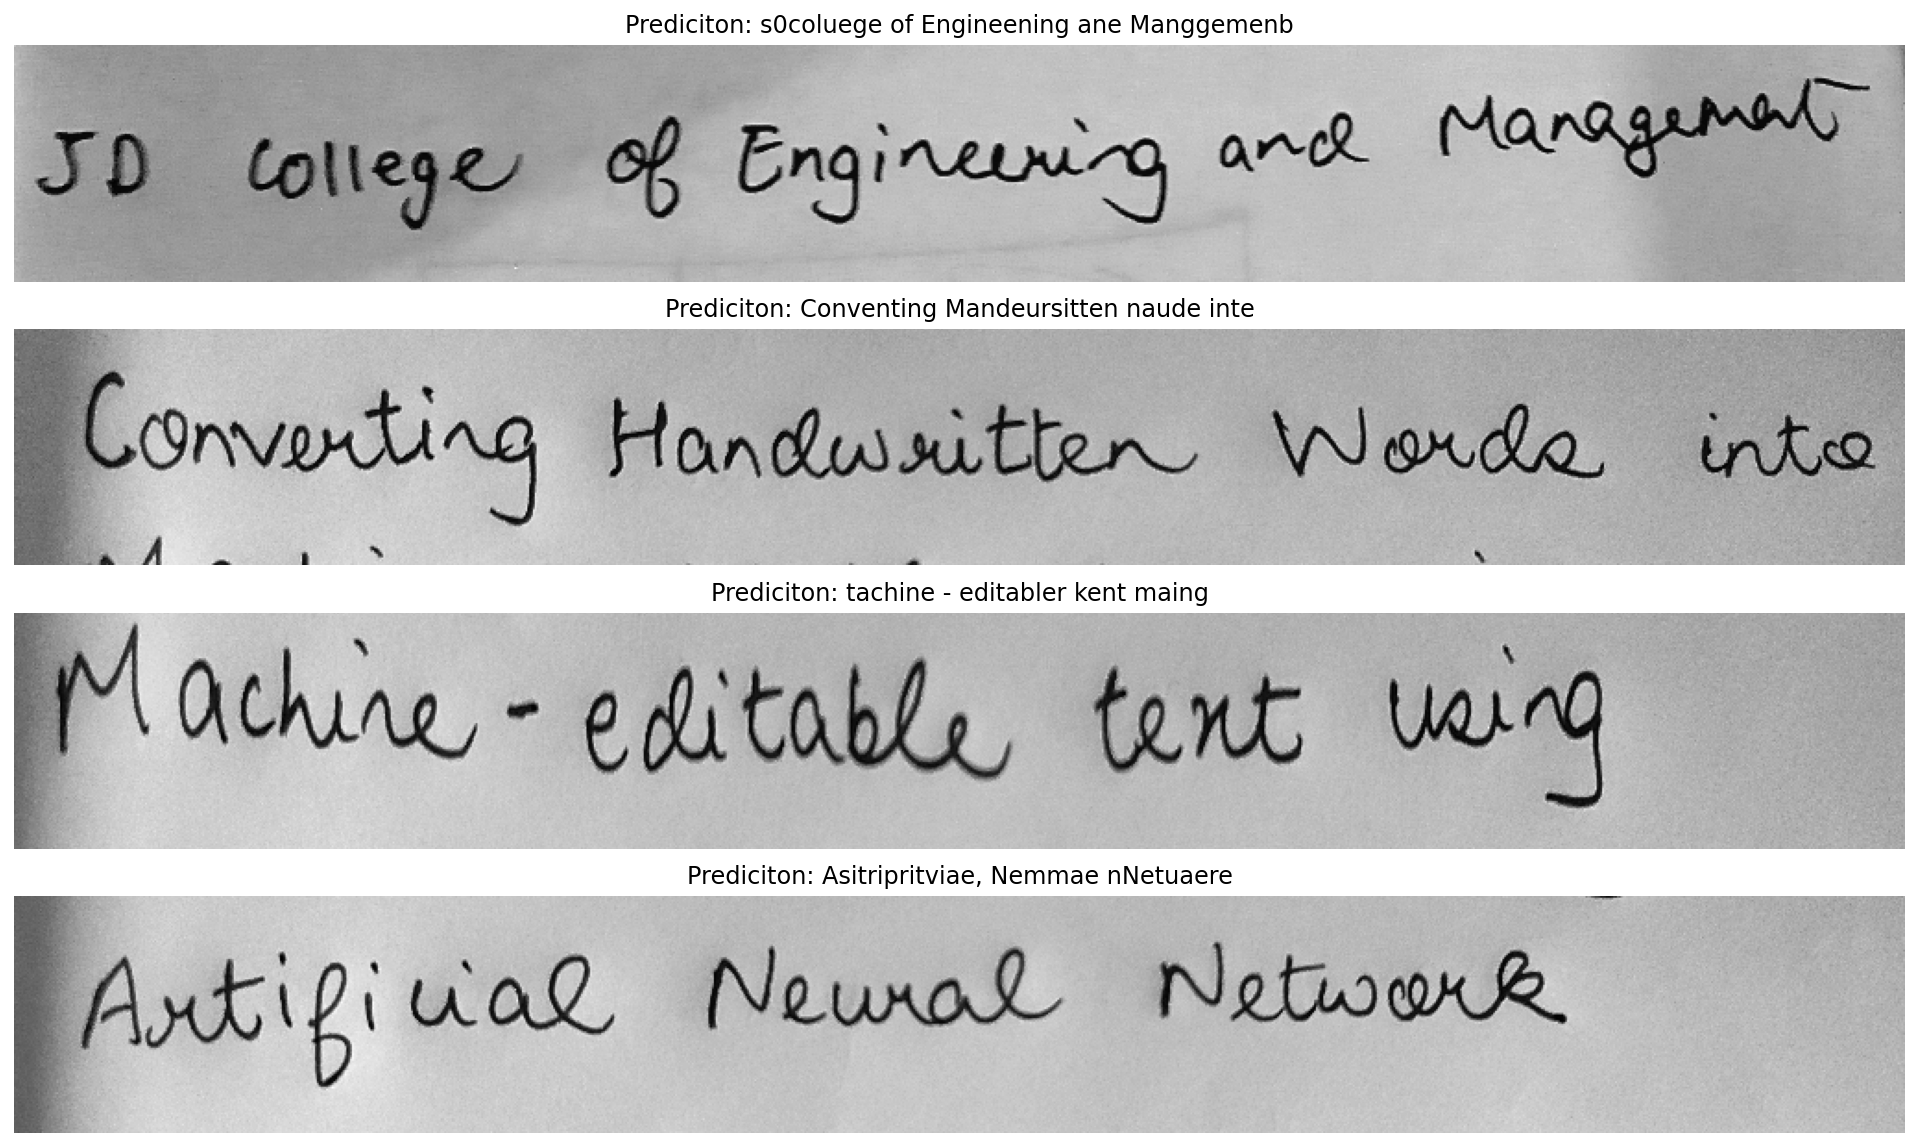

In [13]:
f, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Prediciton: {preds_decoded[i]}")

In [4]:
from main import infer

infer(real_image01)

########################## SHaPPe: ############################ torch.Size([1, 1024, 128])


'I0 colrege of Engineening ande rManagemant'